In [1]:
import pandas as pd
import ptitprince as pt
import numpy as np
import scipy.io
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy.matlib
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from hrf import sample_hrf

### Define subjects

In [2]:
selected_subjects = range(8,27)
excluded_subjects = [13, 14]
selected_subjects = list(set(selected_subjects).symmetric_difference(excluded_subjects))
number_of_subjects = len(selected_subjects)

### Define relevant variables

In [3]:
root_directory = 'P:/3015003.04/Studies/LayerAttention'
hemispheres = ['lh', 'rh']
regressors_of_interest = [
    'Stimulus_{Right,On}',
    'Stimulus_{Left,On}',
    'Stimulus_{Right,Off}',
    'Stimulus_{Left,Off}'
];
regions = ["V1", "V2", "V3"];
hemispheres = ["lh", "rh"];
method = 'OLS';
vertices = 600;
timepoints  = range(-2,16)
layers = ['WM', 'Deep', 'Middle', 'Top', 'CSF']

### Grab time courses from MATLAB files 

In [4]:
timecourses = {}
for hemisphere in hemispheres:
    timecourses[hemisphere] = {}
    for region in regions:
        timecourses[hemisphere][region] = []

for subject in range(len(selected_subjects)):
    subject_directory = '{:s}/SubjectData/Subject{:02d}'.format(root_directory, selected_subjects[subject])
    for region in regions:
        for hemisphere in hemispheres:
            time_course = []
            for chunk in range(1,4):
                timecourse_file ='{:s}/Set{:d}/TimeCourses/{:s}.{:s}_{:d}v_{:s}.mat'.format(
                    subject_directory, chunk, hemisphere, region, vertices, method
                )
                if not os.path.isfile(timecourse_file):
                    continue
                mat = scipy.io.loadmat(timecourse_file)
                time_course += [i[0] for i in mat['timeCourses']]

            time_course = np.concatenate((time_course), axis=1)
            timecourses[hemisphere][region].append(time_course)

### Grab design matrices and run regressions
Put the results in a `pandas` DataFrame

In [5]:
betas = pd.DataFrame(columns = ['Activation', 'Layer', 'TimePoints', 'Hemisphere', 'Subject', 'Region', 'Task'])
for subject in range(len(selected_subjects)):
    subject_directory = '{:s}/SubjectData/Subject{:02d}'.format(root_directory, selected_subjects[subject])
    design_file = '{:s}/DesignMatrix/design_fir.mat'.format(subject_directory);
    mat = scipy.io.loadmat(design_file)
    design_matrix = mat['design']['DesignMatrix'][0,0]
    r = mat['design']['RegressorLabel'][0,0]
    regressors = [i[0][0] for i in np.transpose(r)]
    for region in regions:
        for hemisphere in hemispheres:
            
            model = LinearRegression(fit_intercept=False)
            for layer in list(range(1,4)):
                model.fit(design_matrix, np.transpose(timecourses[hemisphere][region][subject][layer,:]))
                b = pd.DataFrame(columns=regressors)
                b.loc[len(b)] = model.coef_
                for regressor in regressors_of_interest:
                    percent_change = b.filter(regex=(regressor + ".*")).divide(np.mean(b['Constant'].values, 1), 0)
                    a = np.transpose(percent_change).reset_index(drop=True)
                    a.columns = ['Activation']
                    a['Layer'] = layers[layer]
                    a["TimePoints"] = timepoints
                    a['Hemisphere'] = hemisphere
                    a['Subject'] = subject
                    a['Region'] = region
                    a['Task']= regressor
                    betas = betas.append(a)

### Plot response per condition (collapsed over region and layer):

#### Fit HRF and plot in the same figure

In [6]:
def regression_on_single_timecourse(timecourse, regressor):
    model = LinearRegression(fit_intercept=False)
    model.fit(np.transpose(regressor), timecourse)
    return model.coef_[0][0]

onset = 0
duration = 0
hrf_parameters = [5, 10, 0.5, 0.5, 4, 0, 32]
timepoints = np.arange(-2, 16, 1)
timepoints_upsampled = np.arange(-2, 16, 0.1)
hrf = np.array([sample_hrf(timepoints, onset, duration, hrf_parameters=hrf_parameters)])
hrf_upsampled = np.array([sample_hrf(timepoints_upsampled, onset, duration, hrf_parameters=hrf_parameters)])

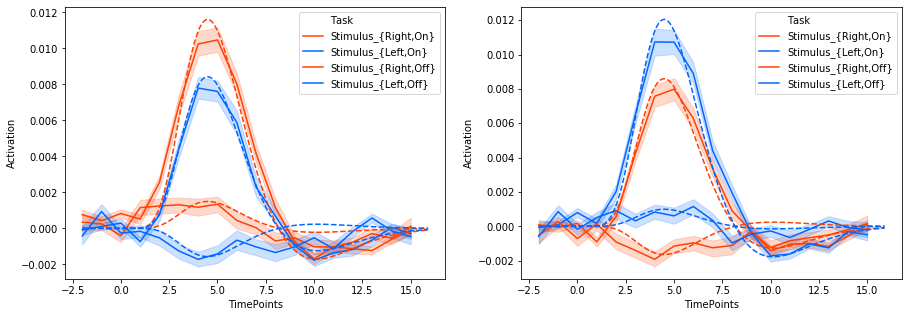

In [7]:
f, axes = plt.subplots(1, 2, figsize = (15,5))
color_palletes = ["#ff4000", "#0066ff", "#ff4000", "#0066ff"]

pal  = sns.color_palette(color_palletes)

for i in range(len(hemispheres)):
    betas_per_hemisphere = betas.query(f"Hemisphere == '{hemispheres[i]}'")
    condition_hrfs = betas_per_hemisphere.groupby(['Task', 'TimePoints']).mean()
    condition_hrfs = [regression_on_single_timecourse(
                    condition_hrfs.query(f"Task == '{regressor}'").values, hrf) 
                      for regressor in regressors_of_interest]
    timecourses = np.array([b * hrf_upsampled for b in condition_hrfs])
    sns.lineplot(
        data=betas_per_hemisphere,
        x="TimePoints", 
        y="Activation",
        palette= pal, 
        hue="Task", 
        ax=axes[i],
    )
    
    for j in range(4):
        axes[i].plot(
            timepoints_upsampled,
            timecourses[j][0],
            '--', 
            color=color_palletes[j]
        )   

### Collapse over hemisphere:

In [8]:
regressors = ["StimAtt", "NoStimAtt", "StimUnatt", "NoStimUnatt"]
betas["Stim"] = False
betas["Stim"].loc[((betas["Hemisphere"] == "lh") & (betas["Task"] == "Stimulus_{Right,On}"))
             | ((betas["Hemisphere"] == "rh") & (betas["Task"] == "Stimulus_{Left,On}"))] = regressors[0]
betas["Stim"].loc[((betas["Hemisphere"] == "lh") & (betas["Task"] == "Stimulus_{Right,Off}"))
             | ((betas["Hemisphere"] == "rh") & (betas["Task"] == "Stimulus_{Left,Off}"))] = regressors[1]
betas["Stim"].loc[((betas["Hemisphere"] == "rh") & (betas["Task"] == "Stimulus_{Right,On}"))
             | ((betas["Hemisphere"] == "lh") & (betas["Task"] == "Stimulus_{Left,On}"))] = regressors[2]
betas["Stim"].loc[((betas["Hemisphere"] == "rh") & (betas["Task"] == "Stimulus_{Right,Off}"))
             | ((betas["Hemisphere"] == "lh") & (betas["Task"] == "Stimulus_{Left,Off}"))] = regressors[3]

C:\Users\timvmou\AppData\Local\Continuum\anaconda3\envs\raincloudplots\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


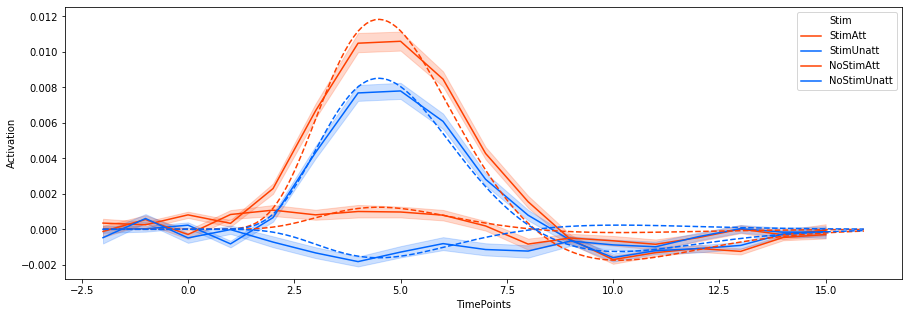

In [9]:
f, axes = plt.subplots(1, 1, figsize = (15,5))

color_palletes = ["#ff4000", "#0066ff", "#ff4000", "#0066ff"]
pal = sns.color_palette(color_palletes)
condition_hrfs = betas.groupby(['Stim', 'TimePoints']).mean()
condition_hrfs = [regression_on_single_timecourse(
                condition_hrfs.query(f"Stim == '{regressor}'").values, hrf) 
                  for regressor in regressors]
timecourses = np.array([b * hrf_upsampled for b in condition_hrfs])
sns.lineplot(
    data=betas,
    x="TimePoints", 
    y="Activation",
    palette= pal, 
    hue="Stim", 
    ax=axes,
)

color_palletes = ["#ff4000", "#ff4000", "#0066ff", "#0066ff"]
for j in range(4):
    axes.plot(
        timepoints_upsampled,
        timecourses[j][0],
        '--', 
        color=color_palletes[j]
    )   

### Compute model fit

In [10]:
df = pd.DataFrame(columns=['Model Fit (r^2)', 'Regressor'])
condition_hrfs = betas.groupby(['Stim', 'TimePoints']).mean()
condition_hrfs = [condition_hrfs.query(f"Stim == '{regressor}'").values for regressor in regressors]
for r in range(len(regressors)):
    df.loc[len(df)] = [regressors[r], np.corrcoef(hrf, np.transpose(condition_hrfs[r]))[0][1] ** 2]

df

,Model Fit (r^2),Regressor
0,StimAtt,0.981814
1,NoStimAtt,0.509033
2,StimUnatt,0.985497
3,NoStimUnatt,0.403665


### Plot over layers

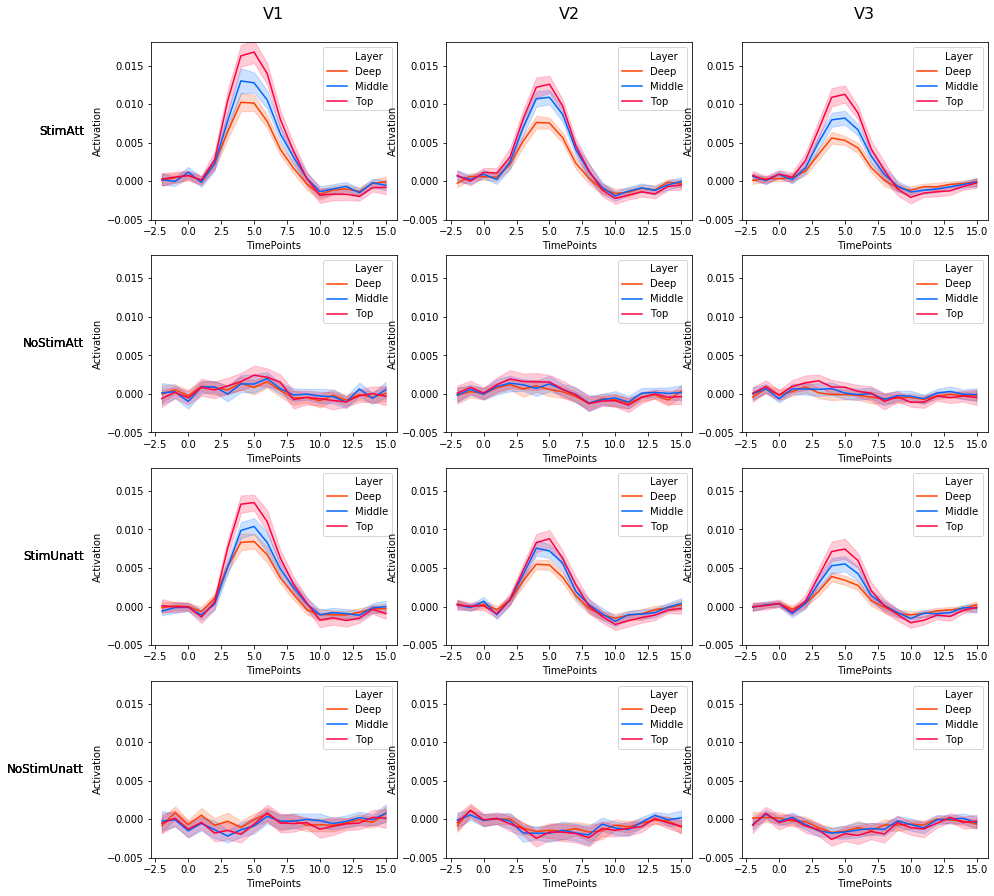

In [11]:
f, axes = plt.subplots(len(regressors), len(regions), figsize = (15,15))

color_palletes = ["#ff4000", "#0066ff", "#ff0040"]
pal  = sns.color_palette(color_palletes)

pad = 5
for j in range(len(regions)):
    axes[0][j].set_title(f"{regions[j]}\n", fontsize=16)
    for i in range(len(regressors)):
        axes[i][0].annotate(
            regressors[i], 
            xy=(0, 0.5), 
            xytext=(-axes[i][0].yaxis.labelpad - pad, 0),
            xycoords=axes[i][0].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='right', 
            va='center'
        )
        
        sns.lineplot(
            data     = betas.query(f"Stim == '{regressors[i]}'").query(f"Region == '{regions[j]}'"),
            x        = "TimePoints", 
            y        = "Activation",
            palette  = pal, 
            hue      = "Layer",
            ax=axes[i,j],
        );
        axes[i,j].set_ylim(-0.005, 0.018)